In [8]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'): 
    for filename in filenames:
        print(os.path.join(dirname, filename))
import copy
import shap
import optuna  

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from tabulate import tabulate
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from optuna.samplers import TPESampler
from sklearn.metrics import precision_score, precision_recall_curve, average_precision_score
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    roc_auc_score, 
    brier_score_loss, 
    confusion_matrix, 
    average_precision_score, 
)
from sklearn.model_selection import TimeSeriesSplit 
        
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

/kaggle/input/creditcardfraud/creditcard.csv


<img src="https://www.abclegal.com/hs-fs/hubfs/iStock-495421971%20(1).jpg?width=1200&name=iStock-495421971%20(1).jpg" alt="Credit Card Fraud" width="800"/>


# 🤖 Credit Card Fraud Detection 💳 Machine Learning

In this notebook we are going to perform exploratory data analysis and iterate through different machine learning models using [Kaggles Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data) dataset. The objective is to build a model which predicts if a transaction is fraudulent (1) or genuine (0) as accuractely as possible. 

In [3]:
creditcard = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
print(f"Rows: {creditcard.shape[0]:,}")
print(f"Cols: {creditcard.shape[1]:,}")
creditcard.head(3)

Rows: 284,807
Cols: 31


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


The dataset consists of 31 columns out of which 28 are anonymized. The named and defined columns are: 

| Column | Description |
| ------ | ----------- |
| `Time` | Number of seconds elapsed between this transaction and the first transaction in the dataset. |
| `Amount` | Amount of the transaction. |
| `Class` | Target class. $0$ if genuine, $1$ if fraudulent. |

In [7]:
creditcard[['Time', 'Amount', 'Class']].dtypes 

Time      float64
Amount    float64
Class       int64
dtype: object

In [25]:
# ----------------------------- #
# Add some time-related columns #
# ----------------------------- #

creditcard['Time_Hours'] = creditcard['Time'] / 3_600
creditcard['Time_Days'] = creditcard['Time_Hours'] / 24
creditcard['Hour_of_Day'] = creditcard['Time'] % 86_400 / 3_600

# Encode as cyclic features which can help ML models understand cyclic nature of time.
creditcard['Hour_sin'] = np.sin(2 * np.pi * creditcard['Hour_of_Day'] / 24)
creditcard['Hour_cos'] = np.cos(2 * np.pi * creditcard['Hour_of_Day'] / 24)

creditcard[['Time', 'Time_Hours', 'Time_Days', 'Hour_of_Day', 'Hour_sin', 'Hour_cos']].head(5)

,Time,Time_Hours,Time_Days,Hour_of_Day,Hour_sin,Hour_cos
0,0.0,0.000000,0.000000,0.000000,0.000000,1.0
1,0.0,0.000000,0.000000,0.000000,0.000000,1.0
2,1.0,0.000278,0.000012,0.000278,0.000073,1.0
3,1.0,0.000278,0.000012,0.000278,0.000073,1.0
4,2.0,0.000556,0.000023,0.000556,0.000145,1.0


# 🌐 Global Variables

In [15]:
# ------------------------------------------------- #
# Global Variables to use across the whole notebook #
# ------------------------------------------------- #
 
RANDOM_STATE = 42

TS = 'Time'
TARGET = 'Class'
MONEY = 'Amount'
LABELS = ['Genuine', 'Fraud']

# 🛠️ Helper Methods

In [ ]:
def return_performance_statistics(model, X_tr, y_tr, X_te, y_te):
    results = {
        'train': {
            'accuracy': None,
            'precision': None,
            'recall': None,
            'auc_roc': None,
            'ap': None,
            'brier': None
        },
        'test': {
            'accuracy': None,
            'precision': None,
            'recall': None,
            'auc_roc': None,
            'ap': None,
            'brier': None
        },
    }

    # --------- #
    # TRAIN_VAL #
    # --------- #
    y_proba_train = model.predict_proba(X_tr)[:, 1]
    y_pred_train = model.predict(X_tr)

    results['train']['accuracy'] = accuracy_score(y_tr, y_pred_train)
    results['train']['precision'] = precision_score(y_tr, y_pred_train)
    results['train']['recall'] = recall_score(y_tr, y_pred_train)
    results['train']['auc_roc'] = roc_auc_score(y_tr, y_proba_train)
    results['train']['ap'] = average_precision_score(y_tr, y_proba_train)
    results['train']['brier'] = brier_score_loss(y_tr, y_proba_train)

    # ---- #
    # TEST #
    # ---- #

    y_proba_test = model.predict_proba(X_te)[:, 1]
    y_proba_test = pd.Series(y_proba_test, index=y_te.index)
    y_pred_test = model.predict(X_te)

    results['test']['accuracy'] = accuracy_score(y_te, y_pred_test)
    results['test']['precision'] = precision_score(y_te, y_pred_test)
    results['test']['recall'] = recall_score(y_te, y_pred_test)
    results['test']['auc_roc'] = roc_auc_score(y_te, y_proba_test)
    results['test']['ap'] = average_precision_score(y_te, y_proba_test)
    results['test']['brier'] = brier_score_loss(y_te, y_proba_test)

    return results

# 📂 Fraud Overview

In [13]:
# --- Get basic statistics ---
pd.DataFrame(
    {
        'Data Type': creditcard.dtypes,
        'Missing Count (#)': creditcard.isnull().sum(),
        'Missing Rate (%)': 100 * creditcard.isnull().mean(),
        'Unique Count (#)': creditcard.nunique(),
        'Unique Rate (%)': round(100 * creditcard.nunique() / creditcard.shape[0], 2),
        'Duplicates Count (#)': [creditcard[c].duplicated().sum() for c in creditcard.columns],
        'Duplicates Rate (%)': [round(100 * creditcard[c].duplicated().sum() / creditcard.shape[0], 2) for c in creditcard.columns],
    }
)

,Data Type,Missing Count (#),Missing Rate (%),Unique Count (#),Unique Rate (%),Duplicates Count (#),Duplicates Rate (%)
Time,float64,0,0.0,124592,43.75,160215,56.25
V1,float64,0,0.0,275663,96.79,9144,3.21
V2,float64,0,0.0,275663,96.79,9144,3.21
V3,float64,0,0.0,275663,96.79,9144,3.21
V4,float64,0,0.0,275663,96.79,9144,3.21
V5,float64,0,0.0,275663,96.79,9144,3.21
V6,float64,0,0.0,275663,96.79,9144,3.21
V7,float64,0,0.0,275663,96.79,9144,3.21
V8,float64,0,0.0,275663,96.79,9144,3.21
V9,float64,0,0.0,275663,96.79,9144,3.21


There are no missing values in the dataset 😊. 

In [20]:
# --- Understand overall fraud behavior ---
100*creditcard[TARGET].value_counts(normalize=True)

overall_fraud_count = creditcard[TARGET].sum()
overall_fraud_rate = overall_fraud_count / creditcard.shape[0]
non_fraud_count = creditcard.shape[0] - overall_fraud_count
overall_non_fraud_rate = non_fraud_count / creditcard.shape[0]

pd.DataFrame({
    'Metric': ['Number of Genuine', 'Number of Fraud', 'Genuine Rate (%)', 'Fraud Rate (%)'],
    'Value': [non_fraud_count, overall_fraud_count, 100*overall_non_fraud_rate, 100*overall_fraud_rate]
})

,Metric,Value
0,Number of Genuine,284315.000000
1,Number of Fraud,492.000000
2,Genuine Rate (%),99.827251
3,Fraud Rate (%),0.172749


The dataset is __highly imbalanced__. It contains only 492 fraudulent transactions, which results in an __overall fraud rate of 0.173%__. Consequently 99.8% of all transactions are genuine. Therefore, later we need to perform some techniques to handle this imbalance. 

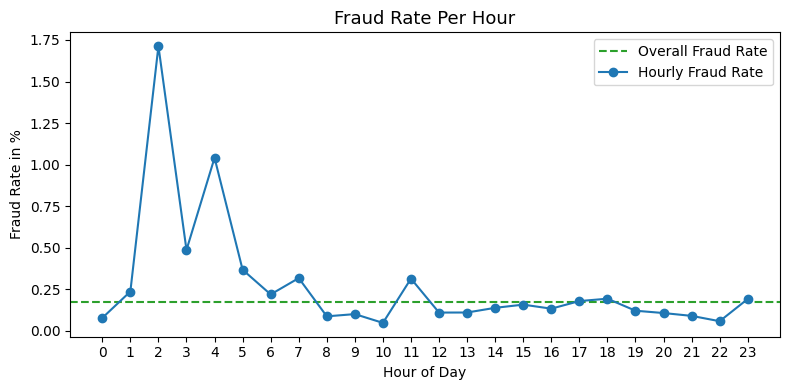

In [37]:
# --------- #
# Preparing #
# --------- #

creditcard['Hour'] = creditcard['Time'] // 3_600 % 24
hourly_fraud_rate = creditcard.groupby('Hour')['Class'].mean().reset_index()
overall_fraud_rate = creditcard['Class'].mean() * 100
hourly_fraud_rate['Class'] *= 100


# -------- #
# Plotting #
# -------- #

plt.figure(figsize=(8, 4))
plt.axhline(y=overall_fraud_rate, color='C2', linestyle='--', label='Overall Fraud Rate')
plt.plot(hourly_fraud_rate['Hour'], hourly_fraud_rate['Class'], linestyle='-', marker='o', color='C0', label='Hourly Fraud Rate')
plt.title('Fraud Rate Per Hour', fontsize=13)
plt.xlabel('Hour of Day')
plt.ylabel('Fraud Rate in %')
plt.xticks(range(0, 24))
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

__Observations__

- The dataset consists of roughly 24 hours of data.
- In the 2nd hour after the first transaction the fraud fraud is the highest, having a value of nearly 1.75%. 
- The hourly fraud rates stabilizes after the 8th hour.

__Insights__

> Most fraud happened in the early morning between 2am and 4am.

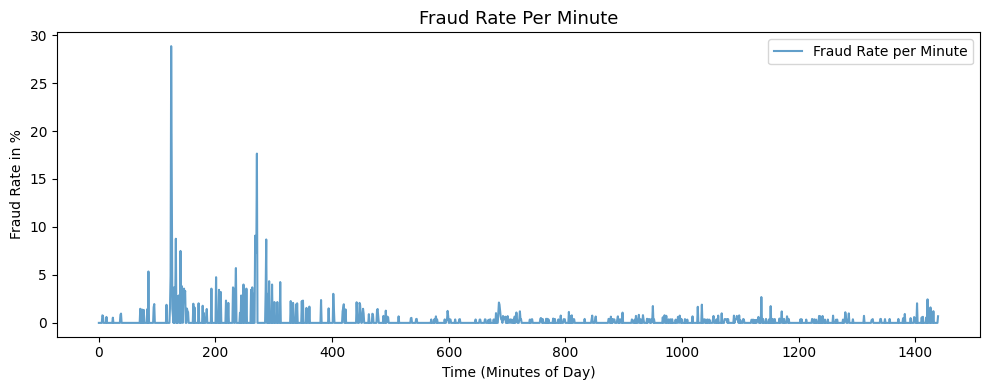

In [39]:
# --------- #
# Preparing #
# --------- #

creditcard['Minute'] = (creditcard['Time'] // 60) % 1440
minute_fraud_rate = creditcard.groupby('Minute')['Class'].mean().reset_index()
minute_fraud_rate['Class'] *= 100


# -------- #
# Plotting #
# -------- #

plt.figure(figsize=(10, 4))

plt.plot(minute_fraud_rate['Minute'], minute_fraud_rate['Class'], linestyle='-', color='C0', 
         label='Fraud Rate per Minute', alpha=0.7)
plt.title('Fraud Rate Per Minute', fontsize=13)
plt.xlabel('Time (Minutes of Day)')
plt.ylabel('Fraud Rate in %')
plt.legend()
plt.grid(False)
plt.tight_layout()

plt.show()

# 💸 Amount

In this subsection we are going to investigate the amount column `Amount`.

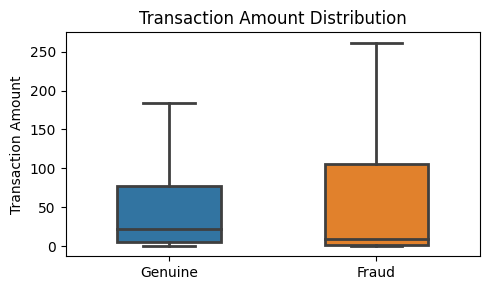

In [54]:
fig, axes = plt.subplots(figsize=(5, 3))

sns.boxplot(data=creditcard, x=TARGET, y=MONEY,
            linewidth=2, width=0.5, showfliers=False, ax=axes)
axes.set_title('Transaction Amount Distribution')
axes.set_xlabel('')
axes.set_ylabel('Transaction Amount')
axes.set_xticklabels(LABELS)

plt.tight_layout()
plt.show()

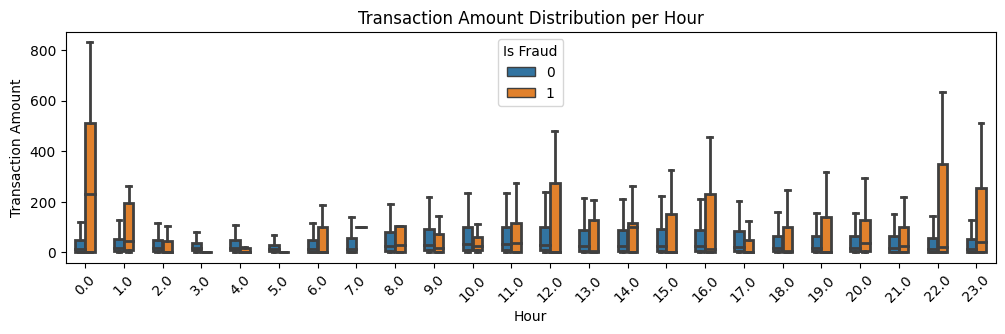

In [57]:
plt.figure(figsize=(12, 3))
sns.boxplot(data=creditcard, x='Hour', y=MONEY, hue=TARGET, linewidth=2, width=0.5, showfliers=False)
plt.title('Transaction Amount Distribution per Hour')
plt.xlabel('Hour')
plt.ylabel('Transaction Amount')
plt.legend(title='Is Fraud')
plt.xticks(rotation=45)
plt.grid(False)
plt.show()

---

💚 Thank you for reading 💚

If you have any questions or feedback, feel free to leave a comment 🤔

This notebook is __still in progress__.

Please __UPVOTE__ if you enjoyed this notebook 🙏